# YouTube Live Capture

> Python module for capturing images from YouTube live

In [ ]:
#| default_exp vision.ytlive

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from datetime import datetime
from IPython.display import Image, display
from pathlib import Path
from PIL import Image
from typing import Optional

import cv2
import glob
import matplotlib.pyplot as plt
import os
import pytesseract
import time
import yt_dlp as youtube_dl

## Youtube Live Capture experiment

This experiment focuses on capturing Youtube Live from public cameras monitoring multiple Näkymä Helsingistä locations. We can first extract information about the Youtube Live using the library `yt_dlp`.

In [ ]:
#| export
# Näkymä Helsingistä location list
nakyma_helsinki_known_places = [
    "Olympiaterminaali",
    "Etelasatama",
    #"Eteläsatama",  # fixup
    "Eteladsatama", # fixup
    "Presidentinlinna",
    "Tuomiokirkko",
    "Kauppatori",
    "Kauppator",    # fixup   
    "Torni",
    "Valkosaari",
]

In [ ]:
#|export
nakyma_helsinkigista_youtube_live_url = "https://www.youtube.com/watch?v=LMZQ7eFhm58"
ydl_opts = {
    'cookiefile': "cookies.txt",  # Path to the exported cookies file,  # Use cookies for authentication
    'download': False  # Set to True if you want to download
}

In [ ]:
#| export
def stream_url(ytlive_url:str, ydl_opts:dict) -> str:
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(ytlive_url, download=False)
        for o in info['formats']:
            if o['resolution'] == '1280x720':
                return o['url']
        else:
            raise ValueError("No 1280x720 format")    

In [ ]:
#| eval: false
stream_url(nakyma_helsinkigista_youtube_live_url, ydl_opts)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading tv player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information


'https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1736836379/ei/u7CFZ4TTI_GRv_IPtvXPuQs/ip/82.130.25.234/id/LMZQ7eFhm58.5/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr2---sn-ovgq0oxu-5goe.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/bui/AY2Et-M1JZbohArqpqIsZTVEI4c_xxZ1YZtUkvEu15V05AlQo0UPIDgAxB2VHMr7q8b0TvHnnRrnNJ5y/spc/9kzgDYZI8zHCYs3PwTjfj3JfxfND85dAsNhfljY8AMb8h2HW1CEo/vprv/1/playlist_type/DVR/initcwndbps/5470000/met/1736814779,/mh/l8/mm/44/mn/sn-ovgq0oxu-5goe/ms/lva/mv/m/mvi/2/pl/18/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51326932,51335594,51353498,51371294/mt/1736814262/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgovp,rqh,hdlc,xpc,playlist_duration,manifest_duration,bui,spc,vprv,playlist_type/sig/AJfQdSswRAIgSRa1XoQ6Px4Gf4USXLK4jUYP5pJOMBkvW1SRlSueiugCIE0u-CFTMfVh3GvSWNpQZXUywLeEWcktrhCcaTsRyQ-G/lsparam

At this point, we have obtained a special link for downloading captures from this livestream. This URL is a dynamically generated link used by YouTube for delivering live streaming content via an HLS (HTTP Live Streaming) protocol. We can proceed to donwload content chunks from this link with `cv2`.

**NOTE**: This livestream contains a small frame at top left corner to display the current time and location. We can attempt to crop this small frame and extract further information from the captured image.

In [ ]:
#| export
def show_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for Matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    plt.show()   

In [ ]:
#| export
def crop_frame(frame, crop=(0, 0, 480, 30)):
    x, y, w, h = crop
    return frame[y:y+h, x:x+w]    

In [ ]:
#| export
def frame_to_text(frame): return pytesseract.image_to_string(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).strip()

In [ ]:
#| export
def known(txt:str, known_places:str) -> str:
    """Try to find one of `known_places` are included in the given `txt`"""
    for o in known_places:
        #print(o, "in", txt)
        if o in txt:
            return o
    raise Exception("No place specified")

In [ ]:
#| hide
assert known("Torninnnnnn", nakyma_helsinki_known_places)=="Torni"

In [ ]:
#| export
def meta(frame, known_places=nakyma_helsinki_known_places, printing=False):
    """Withdraw meta data, datetime & place"""
    # "04.10.2024  14:53:49  Kauppatori", Original format
    txt = frame_to_text(frame)
    if printing==True: print(txt)
    dt = datetime.strptime(txt[:19],"%d.%m.%Y %H:%M:%S")
    pl = known(txt[20:], known_places)
    pl = pl.replace("Eteladsatama", "Etelasatama") # fixup
    pl = pl.replace("ä", "a")                      # fixup
    pl = pl.replace("kauppator", "kauppatori")     # fixup
    return dt, pl

In [ ]:
#| export
def fname(prefix, dt, pl): return f"""{prefix}{dt.strftime("%Y.%m.%d_%H:%M:%S")}_{pl}.jpg"""

Test workflow combining the above utilities and try saving the downloaded file in a local directory:

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading tv player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
Cropped frame:


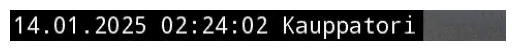

Text in cropped frame: 14.01.2025 02:24:02 Kauppatori
14.01.2025 02:24:02 Kauppatori
File name: cap_2025.01.14_02:24:02_Kauppatori.jpg
Saved to: /home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.14_02:24:02_Kauppatori.jpg


In [ ]:
#| eval: false
url = stream_url(nakyma_helsinkigista_youtube_live_url, ydl_opts)
cap = cv2.VideoCapture(url)
ret, frame = cap.read()
if ret:
    print("Cropped frame:")
    show_frame(crop_frame(frame))

    print("Text in cropped frame:", frame_to_text(crop_frame(frame)))
    try:
        file_name = fname("cap_", *meta(crop_frame(frame), printing=True))
    except:
        file_name = fname("fail_", datetime.now(), "nowhere")
    print("File name:", file_name)
    path = Path(os.getenv("LLMCAM_DATA", "../data"))/file_name
    path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(path, frame)
    print("Saved to:", path)
else:
    print("Failed to capture frame.")

As such, we can follow this guideline for implementing the modularized functions:

1. Extract HSL URL from Youtube Live  
2. Capture live images with this URL  
3. Crop small frame and extract further metadata from captured images  
4. Form suitable file names and save captured images  

## Modularize with Live instances

This section implements the modularized functions with Object-Oriented Programming approach (OOP). Each Youtube Live is managed by a `YTLive` instance, which captures images from its live stream when prompted.

### General Live instance

**NOTE**: For a generic Youtube Live stream, step 3 in the described workflow is skipped and file name is generated as a combination of the current timestamp and user-input location.

In [ ]:
#| export
class YTLive:
    def __init__(
        self,
        url: str,  # YouTube Live URL
        data_dir: Optional[Path] = Path(os.getenv("LLMCAM_DATA", "../data")),  # Directory to store captured images
        place: Optional[str] = "nowhere",  # Location name
    ):
        self.url = url
        self.stream_url = stream_url(url, ydl_opts)
        self.data_dir = data_dir
        self.place = place

    def file_name(self, frame=None):
        return fname("cap_", datetime.now(), self.place)

    def capture(self) -> Path:
        cap = cv2.VideoCapture(self.stream_url)
        ret, frame = cap.read()
        if ret==False:
            raise Exception("Failed to capture frame.")
        fn = self.data_dir/self.file_name(frame)
        cv2.imwrite(fn, frame)
        return fn     

    def __call__(self):
        # __call__ method allows the instance to be called like a function
        return self.capture()

In [ ]:
show_doc(YTLive)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/ytlive.py#L97){target="_blank" style="float:right; font-size:smaller"}

### YTLive

>      YTLive (url:str, data_dir:Optional[pathlib.Path]=Path('/home/nghivo/tinyM
>              LaaS/llmcam/data'), place:Optional[str]='nowhere')

*Initialize self.  See help(type(self)) for accurate signature.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| url | str |  | YouTube Live URL |
| data_dir | Optional | /home/nghivo/tinyMLaaS/llmcam/data | Directory to store captured images |
| place | Optional | nowhere | Location name |

Test usage with a different live stream of Santa Claus Village:

In [ ]:
#| eval: false
SantaClausVillage = YTLive(url="https://www.youtube.com/live/Cp4RRAEgpeU?si=IwqJ4QU1Umv9PdgW", place="santaclausvillage")
file = SantaClausVillage()
print()
print("File path:", file)

[youtube] Extracting URL: https://www.youtube.com/live/Cp4RRAEgpeU?si=IwqJ4QU1Umv9PdgW
[youtube] Cp4RRAEgpeU: Downloading webpage
[youtube] Cp4RRAEgpeU: Downloading ios player API JSON
[youtube] Cp4RRAEgpeU: Downloading tv player API JSON
[youtube] Cp4RRAEgpeU: Downloading m3u8 information

File path: /home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.14_02:33:09_santaclausvillage.jpg


### Näkymä Helsingistä Live instance

We also add a special support for Näkymä Helsingistä livestream that utilizes the small frame at top left corner to extract metadata and generate file names. This is a subclass that inherits all other functions from `YTLive` while modifying the `file_name` function.

In [ ]:
#| export
class NHsta(YTLive):
    def __init__(
        self,
        url: Optional[str] = "https://www.youtube.com/watch?v=LMZQ7eFhm58", # YouTube Live URL
        data_dir: Optional[Path] = Path(os.getenv("LLMCAM_DATA", "../data")), # Directory to store captured images
        place: Optional[str] = "unclear", # Location name if OCR fails
    ):
        super().__init__(url, data_dir, place)
    
    def file_name(self, frame):
        try:        
            path = fname("cap_", *meta(crop_frame(frame), printing=True))
        except Exception as e:
            path = super().file_name()
            print(path)
        return path

In [ ]:
show_doc(NHsta)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/ytlive.py#L126){target="_blank" style="float:right; font-size:smaller"}

### NHsta

>      NHsta (url:Optional[str]='https://www.youtube.com/watch?v=LMZQ7eFhm58', d
>             ata_dir:Optional[pathlib.Path]=Path('/home/nghivo/tinyMLaaS/llmcam
>             /data'), place:Optional[str]='unclear')

*Initialize self.  See help(type(self)) for accurate signature.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| url | Optional | https://www.youtube.com/watch?v=LMZQ7eFhm58 | YouTube Live URL |
| data_dir | Optional | /home/nghivo/tinyMLaaS/llmcam/data | Directory to store captured images |
| place | Optional | unclear | Location name if OCR fails |

Test usage:

In [ ]:
#| eval: false
NakymaHelsingista = NHsta()
file = NakymaHelsingista()
print()
print("File path:", file)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading tv player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
14.01.2025 02:24:07 Kauppatori

File path: /home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.14_02:24:07_Kauppatori.jpg


Try showing the cropped small frame from saved file:

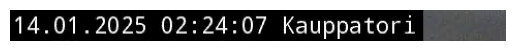

In [ ]:
#| eval: false
def crop_image(path, crop=(0, 0, 480, 30)): return Image.open(path).crop(crop)
def show_image(path):
    plt.imshow(crop_image(path))
    plt.axis('off')
    plt.show()

show_image(file)

### General-purpose function for Function calling

For simplification purpose, we implement a general-purpose function that initiate these Live instances and download file to be used in GPT Function calling:

In [ ]:
#| export
def capture_youtube_live_frame(
        link: Optional[str] = None,  # YouTube Live link
        place: Optional[str] = None,  # Location of live image
    ) -> str:  # Path to the saved image
    """Capture a jpeg image from YouTube Live and return the path to the saved image"""
    if link is not None:
        live = YTLive(url=link, place=place)
    
    else:
        live = NHsta()
    return str(live())

In [ ]:
show_doc(capture_youtube_live_frame)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/ytlive.py#L144){target="_blank" style="float:right; font-size:smaller"}

### capture_youtube_live_frame

>      capture_youtube_live_frame (link:Optional[str]=None,
>                                  place:Optional[str]=None)

*Capture a jpeg image from YouTube Live and return the path to the saved image*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| link | Optional | None | YouTube Live link |
| place | Optional | None | Location of live image |
| **Returns** | **str** |  | **Path to the saved image** |

### Utility function for default Youtube Links

Utility function for saving and retrieving some notable Youtube links.

In [ ]:
#| export
# Define the function for selecting Youtube Live URL
def select_youtube_live_url(
        location: Optional[str] = "Helsinki",  # Location name, one of ["santaclausvillage", "parkinglot", "helsinki", "satellite"]
    ):
    """Select the Youtube Live URL based on the location name"""
    if "santa" in location.lower():
        return "https://www.youtube.com/watch?v=Cp4RRAEgpeU"
    if "parking" in location.lower():
        return "https://www.youtube.com/watch?v=mwN6l3O1MNI"
    if "satellite" in location.lower():
        return "https://www.youtube.com/watch?v=xRPjKQtRXR8"
    else:
        return "https://www.youtube.com/watch?v=LMZQ7eFhm58"

In [ ]:
show_doc(select_youtube_live_url)

---

### select_youtube_live_url

>      select_youtube_live_url (location:Optional[str]='Helsinki')

*Select the Youtube Live URL based on the location name*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| location | Optional | Helsinki | Location name, one of ["santaclausvillage", "parkinglot", "helsinki", "satellite"] |

## Simulated GPT workflow

Test integrating with our current GPT framework:

In [ ]:
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema

tools = [function_schema(capture_youtube_live_frame, "Youtube Live Capture")]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Hi, can you capture YouTube Live?")
])
complete(messages, tools)
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture YouTube Live?
>> Assistant:
Yes, I can capture a frame from a YouTube Live stream. Please provide the link to the YouTube Live
stream you want to capture.


In [ ]:
#| eval: false
# Continue the conversation
messages.append(form_msg("user", "You can use the default link."))
complete(messages, tools=tools)
print_msgs(messages)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading tv player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
01.2025 02:24:12
cap_2025.01.14_02:33:15_unclear.jpg
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture YouTube Live?
>> Assistant:
Yes, I can capture a frame from a YouTube Live stream. Please provide the link to the YouTube Live
stream you want to capture.
>> User:
You can use the default link.
>> Assistant:
I have captured a frame from the YouTube Live stream using the default link. You can find the image
[here](sandbox:/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.14_02:33:15_unclear.jpg).


Another scenario (selecting with location):

In [ ]:
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema

tools = [
    function_schema(capture_youtube_live_frame, "Youtube Live Capture"),
    function_schema(select_youtube_live_url, "Select Youtube Live URL")
]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Hi, can you capture an image from Santa Claus Village?")
])
complete(messages, tools)
print_msgs(messages)

[youtube] Extracting URL: https://www.youtube.com/watch?v=Cp4RRAEgpeU
[youtube] Cp4RRAEgpeU: Downloading webpage
[youtube] Cp4RRAEgpeU: Downloading ios player API JSON
[youtube] Cp4RRAEgpeU: Downloading tv player API JSON
[youtube] Cp4RRAEgpeU: Downloading m3u8 information
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture an image from Santa Claus Village?
>> Assistant:
I've captured an image from Santa Claus Village. You can view it
[here](sandbox:/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.14_02:33:41_santaclausvillage.jpg).


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()